## Equipo 09 - Hola Cetáceos 
##Diplomado de Inteligencia Artificial y Aprendizaje Profundo 
##Universidad Nacional de Colombia 
1. Giovanny C.Londoño
2. Diana M. Rincón
3. Carlos Uriel Romero 

## Hola Cetáceos!!

Este cuaderno busca analizar 1698 extractos de sonidos de 32 especies de mamiferos marinos en el diferentes localizaciones geográficas en el mundo. La fuente de datos original pertenece Watkings Marine Mammals Souds Data Base, estas grabaciones se han recopilado por mas de 7 decadas, y se han recogido con diferentes dispositivos como: VCR, cassettes, phonograph, compuer digital, y optimal disk.

Cada audio corresponde a una secuencia de actividad vocal de un mamífero marino, la página de Watkings es la siguiente: [Watkings](https://cis.whoi.edu/science/B/whalesounds/index.cfm) la distribución geográfica de los audios se muestra a continuación:

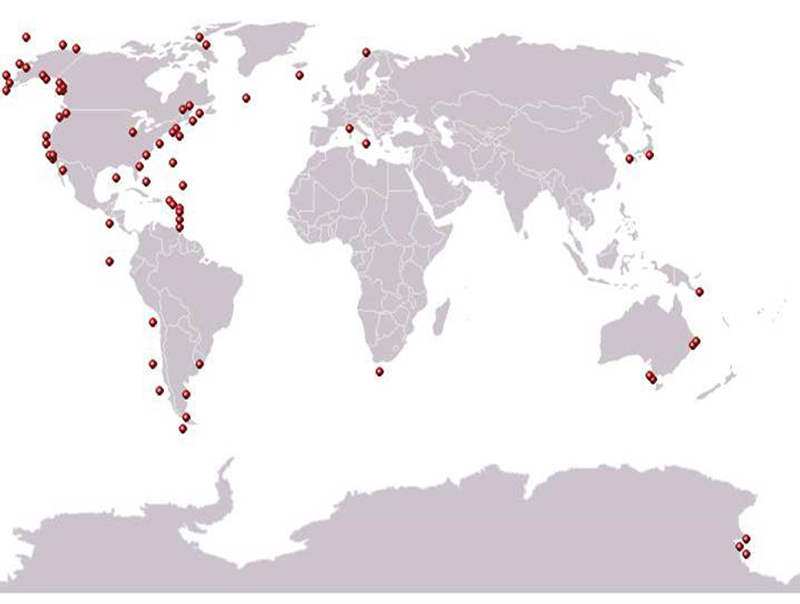


Este notebook se realizó con las siguientes versiones:

* Python 3.7.10
* NumPy 1.19.5
* Pandas 1.1.5
* librosa 0.8.0
* tensorflow 2.4.1
* re 2.2.1
* Scikit-learn 0.22.2.post1
* scipy 1.4.1

## Importar paquetes

In [ ]:
!pip install -U scikit-learn 
import pandas as pd
import numpy as np
import librosa
import librosa.display
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import re
import sklearn
import tensorflow as tf
import scipy
%pylab inline

     |████████████████████████████████| 22.3MB 1.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
!python --version
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('librosa', librosa.__version__)
print('tensorflow', tf.__version__)
print('re', re.__version__)
print('Scikit-learn', sklearn.__version__)
print('scipy', scipy.__version__)

Python 3.7.10
NumPy 1.19.5
Pandas 1.1.5
librosa 0.8.0
tensorflow 2.4.1
re 2.2.1
Scikit-learn 0.24.2
scipy 1.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones para apoyar visualización y preprocesamiento
---

In [ ]:
pathdir = 'drive/MyDrive/Cetaceos/Audios/'
listdir = os.listdir(pathdir)

In [ ]:
from numpy.random import randint
from scipy.fft import fft

def plot_audio(audio_random, new_sr= None):
  """
  Esta función toma la ruta del audio y
  entrega 4 graficas:
  1. Amplitud vs tiempo
  2. Transfomrada de fourier
  3. Espectograma Transformada de Furier corta
  4. Espectograma en escala de Mel
  """
  ################ plot Amplitud vs. tiempo ##########
  #original
  if new_sr == None:
    get_sr = librosa.get_samplerate(audio_random)
    y, sr = librosa.load(audio_random, sr= get_sr, res_type='kaiser_fast')
  else:
    get_sr = librosa.get_samplerate(audio_random)
    y, sr = librosa.load(audio_random, sr= get_sr, res_type='kaiser_fast')
    new_y = librosa.resample(y, sr, new_sr)
    y, sr = new_y, new_sr

  fig, ax = plt.subplots(2, 2, figsize=(18, 7))
  #plt.title(f'{listdir[n]}')
  fig.suptitle(f'{listdir[n]}', fontsize=16, y=1.05, fontweight='bold')
  print(listdir[n])
  librosa.display.waveplot(y, sr= sr, ax= ax[0, 0])
  ax[0, 0].set_title('Amplitud vs. tiempo')

  ############# plot espectograma ############
  #angulos de complejos
  hop_length = 512
  n_fft = 1024 # frame length 
  #Short-Time-Fourier-Transform
  stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
  #Separar resultado en parte de magnitud y fase
  stft_magnitude, stft_phase = librosa.magphase(stft)
  # Pasar amplitud a decibeles para espectrograma
  stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)
  #Mostrar Espectrograma
  librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                          sr=sr, hop_length=hop_length, ax= ax[0, 1])
  ax[0, 1].set_title('stft spectogram')
  
  ############### Transf. Fourier #####################
  Tfy = np.real(fft(y))
  #Dominio de Frecuencias
  N=len(y)
  xf = np.linspace(0.0, 1.0/(2.0*1/sr), N//2)
  ax[1, 0].plot(xf, 2.0/N *np.abs(Tfy[0:N//2]));
  ax[1, 0].set_xlabel('Frequency (Hz)')
  ax[1, 0].set_title('fft')

  ############### mel spectogram ############
  # number of mel frequency bands 
  n_mels = 100
  fmin = 0            
  fmax = 22050 # sample_rate/2
  mel_spec = librosa.feature.melspectrogram(y, n_fft=n_fft, hop_length=hop_length,
                                            n_mels=n_mels, sr= sr, power=1.0,
                                            fmin=fmin, fmax=fmax)
  mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
  img=librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                          sr=sr, hop_length=hop_length, 
                          fmin=fmin, fmax=fmax, ax=ax[1, 1])
  ax[1, 1].set_title('Mel spectogram')
  plt.tight_layout();

In [ ]:
from sklearn import preprocessing
#Correr esta celda solo si nunca a creado el df_full y ya este en local
def get_metadata(pathdir):
  """
  Esta función recibe la ruta de la carpeta y 
  retorna un data frame con la metadata de 
  todos los audios de cetáceos.
  """
  listdir = os.listdir(pathdir)
  dic = {}
  dic['Cetáceo'] = []
  dic['Duración'] = []
  dic['mean'] = []
  dic['std'] = []
  dic['A max'] = []
  dic['A min'] = []
  dic['número'] = []

  count = 0
  for audio in listdir:
      count += 1
      y, sr = librosa.load(pathdir+audio)
      duration = len(y)/float(sr)
      split_name = re.split(r'(\d*\.)', audio, maxsplit=2)
      split_name[1] = int(re.sub(r'[\.]', '', split_name[1]))
      dic['Cetáceo'].append(split_name[0])
      dic['número'].append(split_name[1])
      dic['Duración'].append(duration)
      dic['mean'].append(y.mean())
      dic['std'].append(y.std())
      dic['A max'].append(max(y))
      dic['A min'].append(min(y))
              
      if count%100 == 0:
          print(f'iteración: {count}')
  dic['etiqueta'] = preprocessing.LabelEncoder().fit_transform(dic['Cetáceo'])
  df_full = pd.DataFrame.from_dict(dic)
  return df_full

In [ ]:
def dict_label2encoded(listdir):
  cetaceo = []
  for i in range(0, len(listdir)):
    split_name = re.split(r'(\d*\.)', listdir[i], maxsplit=2)
    split_name[1] = int(re.sub(r'[\.]', '', split_name[1]))
    cetaceo.append(split_name[0])

  Lable_encoder = preprocessing.LabelEncoder().fit(cetaceo)
  mat_labels = {i: name for i, name in enumerate(Lable_encoder.inverse_transform(range(0, 32)))}
  return mat_labels

## Exploración dataframe de entrada
---

In [ ]:
df_metadata = get_metadata(pathdir)
df_metadata

iteración: 100
iteración: 200
iteración: 300
iteración: 400
iteración: 500
iteración: 600
iteración: 700
iteración: 800
iteración: 900
iteración: 1000
iteración: 1100
iteración: 1200
iteración: 1300
iteración: 1400
iteración: 1500
iteración: 1600


,Cetáceo,Duración,mean,std,A max,A min,número,etiqueta
0,Northern Right Whale,1.632971,0.004411,0.056290,0.209099,-0.233832,3,19
1,Narwhal,1.418005,0.000817,0.100957,0.596484,-0.239257,36,18
2,Northern Right Whale,1.180726,0.004469,0.041974,0.171051,-0.158033,9,19
3,Narwhal,1.418005,0.000923,0.106066,0.613161,-0.252821,40,18
4,Narwhal,1.418005,0.000730,0.076215,0.599164,-0.240963,42,18
...,...,...,...,...,...,...,...,...
1692,Northern Right Whale,1.350884,0.004623,0.040215,0.199282,-0.219047,4,19
1693,Northern Right Whale,1.450884,0.003503,0.112605,0.560252,-0.611436,1,19
1694,Northern Right Whale,0.686485,0.004645,0.055316,0.205762,-0.201355,8,19
1695,Northern Right Whale,2.775510,0.004677,0.035155,0.236516,-0.281868,6,19


In [ ]:
df_metadata.describe()

,Duración,mean,std,A max,A min,número,etiqueta
count,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000
mean,10.429681,-0.000009,0.041447,0.263143,-0.261837,31.642899,15.715380
std,71.244984,0.003680,0.036060,0.199036,0.197034,21.391560,9.148845
min,0.053696,-0.024447,0.000317,0.005307,-1.228579,1.000000,0.000000
25%,1.130975,-0.000255,0.016720,0.111296,-0.358799,14.000000,8.000000
50%,1.700816,0.000873,0.031820,0.212609,-0.215971,29.000000,16.000000
75%,3.234785,0.001311,0.054725,0.369584,-0.115069,46.000000,24.000000
max,1260.000000,0.014554,0.257495,1.089886,-0.001450,114.000000,31.000000


In [ ]:
#descarga en formato csv
df_metadata.to_csv (r'/content/drive/MyDrive/Cetaceos/df_metadata.csv', index = False, header=True) #en drive

In [ ]:
#carga el csv desde drive
df_metadata = pd.read_csv (r'/content/drive/MyDrive/Cetaceos/df_metadata.csv') #en drive
df=df_metadata[['Cetáceo','número']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


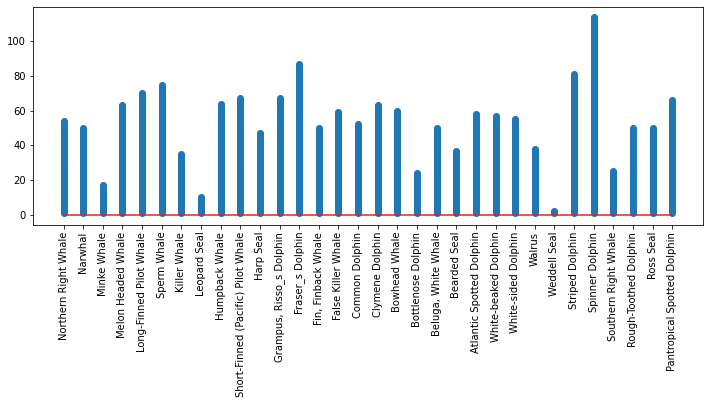

In [ ]:
x=df["Cetáceo"]
y=df["número"]
plt.figure(figsize=(12,4))
plt.stem(x, y)
plt.xticks(plt.xticks()[0], rotation=90)
plt.show() 

## Visualización de casos escogidos aleatoriamente
---

Spinner Dolphin46.mp4


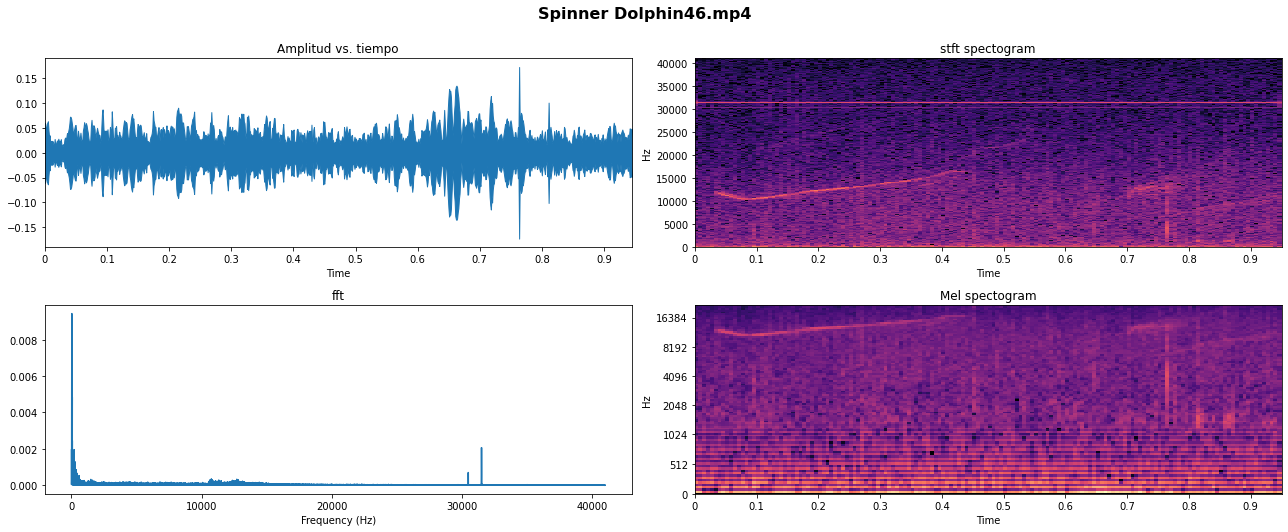

In [ ]:
n = randint(0, len(listdir))
audio_random = pathdir+listdir[n]
plot_audio(audio_random)
get_sr = librosa.get_samplerate(audio_random)
y, sr = librosa.load(audio_random, sr= get_sr)
ipd.Audio(y, rate=sr)

## Entubamiento (Pipelines)
---

In [ ]:
from sklearn import preprocessing

def generator():
  cetaceo = []
  for i in range(0, len(listdir)):

    split_name = re.split(r'(\d*\.)', listdir[i], maxsplit=2)
    split_name[1] = int(re.sub(r'[\.]', '', split_name[1]))
    cetaceo.append(split_name[0])

  etiquetas = preprocessing.LabelEncoder().fit_transform(cetaceo)

  for i in range(0, len(listdir)):
    get_sr = librosa.get_samplerate(pathdir+listdir[i])
    y, sr = librosa.load(pathdir+listdir[i], sr= get_sr)
    y, sr= librosa.load(pathdir+listdir[i], res_type='kaiser_fast')
    mfccs=np.mean(librosa.feature.mfcc(y=y,sr=sr, 
                                         n_mfcc=60).T,axis=0)
    #print(img_resize.shape, etiquetas[i].shape)
    print("@", end='')
    yield mfccs, etiquetas[i]


In [ ]:
######################
batch_size = 64
######################
print(f'número de batch: {round(len(listdir)/batch_size)} de tamaño {batch_size}')
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape= 60, 
                                                                       dtype=tf.float64), 
                                                                       tf.TensorSpec(shape=(), 
                                                                       dtype=tf.int32))).cache().shuffle(len(listdir), reshuffle_each_iteration=False).batch(batch_size)#no colocar.repeat() #shuffle si afecta la generación
                                                                                                                                  #no colocar reshuffle: cada ves que lo ejecutemos barajará diferente
                                                                                                                                  #cache(): sirve para no tenenr que generar todo de nuevo cada ves que se reinicie el generador
print(dataset.element_spec)                                                                                                                                  


número de batch: 27 de tamaño 64
(TensorSpec(shape=(None, 60), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))



## Ajustar modelos
---

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay
print("Versión de Tensorflow:", tf.__version__)

Versión de Tensorflow: 2.4.1


In [ ]:
num_batch = int(len(listdir)/batch_size)
print(len(listdir)/batch_size)
print(f'prueba 10%: take {round(num_batch*0.1)} batches') #10
print(f'val 10%: take {round(num_batch*0.1)} batches') #10
print(f'train 80%: take {round(num_batch*0.8)} batches') #80
num_batch_train = round(num_batch*0.8)
num_batch_val = round(num_batch*0.1)

train_dataset = dataset.take(num_batch_train)
test_dataset = dataset.skip(num_batch_train).take(num_batch_val)
evaluate_dataset = dataset.skip(num_batch_train + num_batch_val).take(num_batch_val)

#train_dataset = dataset.skip(num_batch_train)
print(test_dataset.element_spec) #shape de las etiquetas
print(train_dataset.element_spec)
print(evaluate_dataset.element_spec)

26.515625
prueba 10%: take 3 batches
val 10%: take 3 batches
train 80%: take 21 batches
(TensorSpec(shape=(None, 60), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 60), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 60), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
print(f'train_dataset batches: {len(list(train_dataset.as_numpy_iterator()))}')
print(f'test_dataset batches: {len(list(test_dataset.as_numpy_iterator()))}') 
print(f'evaluate_dataset batches: {len(list(evaluate_dataset.as_numpy_iterator()))}')#numero de batches

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1448
  n_fft, y.shape[-1]


@@@@@@@@@@

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1812
  n_fft, y.shape[-1]


@@@@@@@@@@@@@@@@@@@@@@

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]


@@@@@@@

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1184
  n_fft, y.shape[-1]


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
#ahora hacemos que cada uno se repita indefinidamente para entrenar varias epochs
train_dataset  = train_dataset.repeat()
test_dataset = test_dataset.repeat()
evaluate_dataset = evaluate_dataset.repeat()

## Modelo 01 Denso con 32
---

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_inicial (InputLayer)    [(None, 60)]              0         
_________________________________________________________________
activation (Activation)      (None, 60)                0         
_________________________________________________________________
Primera_capa_oculta (Dense)  (None, 128)               7808      
_________________________________________________________________
Primera_capa_dropout (Dropou (None, 128)               0         
_________________________________________________________________
Segunda_capa_oculta (Dense)  (None, 128)               16512     
_________________________________________________________________
Segunda_capa_dropout (Dropou (None, 128)               0         
_________________________________________________________________
Tercera_capa_oculta (Dense)  (None, 128)               16512 

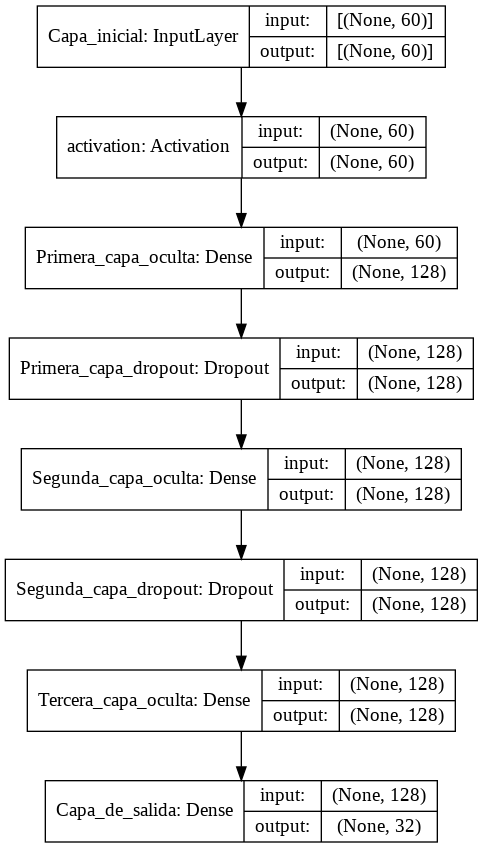

In [ ]:
inputs=Input(shape=(60,), name='Capa_inicial')

model_32M=Activation('tanh')(inputs)
model_32M=Dense(128, activation='relu', name='Primera_capa_oculta')(model_32M)
model_32M= Dropout(.4, name='Primera_capa_dropout')(model_32M)
model_32M=Dense(128, activation='relu', name='Segunda_capa_oculta')(model_32M)
model_32M= Dropout(.4, name='Segunda_capa_dropout')(model_32M)
model_32M=Dense(128, activation='relu', name='Tercera_capa_oculta')(model_32M)


outputs=Dense(32,name='Capa_de_salida')(model_32M)

model_32M=Model(inputs=inputs, outputs=outputs)

model_32M.summary()
plot_model(model_32M, to_file='drive/MyDrive/Cetaceos/model_32M.png', show_shapes=True)

In [ ]:
epocas = 2

print(f'TRAIN: \nEn {epocas} épocas debe haber {round(num_batch*0.8)/epocas} steps_per_epoch')
print(f'TEST: \nEn {epocas} épocas debe haber {round(num_batch*0.1)/epocas} validation_steps')

TRAIN: 
En 2 épocas debe haber 10.5 steps_per_epoch
TEST: 
En 2 épocas debe haber 1.5 validation_steps


## Aplicar Modelo 01
---

In [ ]:
model_32M.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model_32M.fit(train_dataset, epochs= 300,
                      validation_data= test_dataset, 
                      steps_per_epoch= round((num_batch*0.8)/epocas), 
                      validation_steps= round((num_batch*0.1)/epocas))
  #validation_steps= y steps_per_epoch= es fundamental para que no salga n/unknow en los pasos

Epoch 1/300
10/10 [==============================] - 3s 20ms/step - loss: 3.5854 - accuracy: 0.0442 - val_loss: 3.2804 - val_accuracy: 0.2031
Epoch 2/300
10/10 [==============================] - 0s 5ms/step - loss: 3.3482 - accuracy: 0.0963 - val_loss: 3.1064 - val_accuracy: 0.2656
Epoch 3/300
10/10 [==============================] - 0s 5ms/step - loss: 3.1874 - accuracy: 0.1348 - val_loss: 2.9193 - val_accuracy: 0.3281
Epoch 4/300
10/10 [==============================] - 0s 4ms/step - loss: 3.0263 - accuracy: 0.2016 - val_loss: 2.6638 - val_accuracy: 0.3438
Epoch 5/300
10/10 [==============================] - 0s 6ms/step - loss: 2.9079 - accuracy: 0.2175 - val_loss: 2.4885 - val_accuracy: 0.3906
Epoch 6/300
10/10 [==============================] - 0s 5ms/step - loss: 2.7304 - accuracy: 0.2011 - val_loss: 2.3017 - val_accuracy: 0.4375
Epoch 7/300
10/10 [==============================] - 0s 5ms/step - loss: 2.6676 - accuracy: 0.2383 - val_loss: 2.2306 - val_accuracy: 0.4531
Epoch 8/300


In [ ]:
model_32M.evaluate(evaluate_dataset, steps=round((num_batch*0.1))) 

3/3 [==============================] - 0s 4ms/step - loss: 1.0297 - accuracy: 0.7019


[1.02974271774292, 0.7018633484840393]

In [ ]:
model_32M.save('/content/drive/MyDrive/Cetaceo/Cetaceos_32dense.h5') #guardamos el modelo entrenado y evaluado

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
295,0.469315,0.823438,1.347533,0.656250,295
296,0.424511,0.857813,1.338611,0.656250,296
297,0.435383,0.854688,1.323893,0.656250,297
298,0.427135,0.839063,1.357635,0.640625,298
299,0.487528,0.829687,1.287946,0.609375,299


## Análisis de performance Modelo 01
---

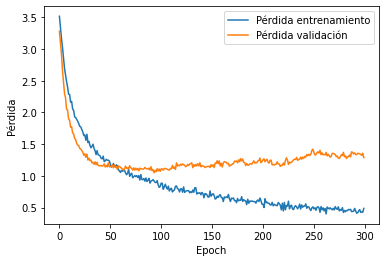

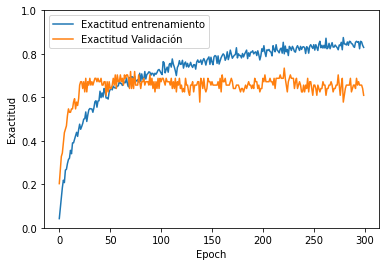

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],
           label='Pérdida entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Pérdida validación')
  #plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Exactitud')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Exactitud entrenamiento')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Exactitud Validación')
  plt.ylim([0,1])
  plt.legend()
  plt.show()
plot_history(history)

Predichas: [23 24 26 26 27 26  6  6 16 10 16  3 22 31 22 23 22 15  6  5 23  9  4 16
 12  8 26 20 13 25 24 15  6 25 27 30  5 26 15 26  9  0 15  4 23 26 11 14
 12 20 16 28 21 19 30  6  5 27  7  0  7  4 30 26  6 25 18 19 10 20 25  7
 25  7 31  7  0 23  2 30 26 21 31 22 26 27 27  7 25 23  1 14 26 11  6  4
  9  9 27 10 22 23 17  8  0 15  2  6  9  6  9 15 23 17  5 12 16  1 15 31
 25  0 11  4  5 20  0  9 26 26 30 15 18 27 15  5  8  5 23  1 10 13 10 16
 21 19 12 16  4  2 22 24 18  9 12  9 19 20 27  8  9]
Reales: [23 12 18 26 27 18 16  6 16 10 16  3 22 31 22 23 22 25 31  5 23  9  1  0
 12  8 26 20  9 25 24  9 27 25 27 30  5 26 23 26  9  0  6  4 25 26 11 14
 12 20  0 28 21 19 30  9  5 27  7  0 10 28 30  9 22 25 23 19 10 20 16  7
 11 10 31  7  0 23  2 30 26 21 31 16 26 27 27  7 18 23  1 14 26 28 23  4
  5  9  3 10 27 23 17  8  0 15  2 27  9 15  9 15  3 17  5 12 16  1 15 31
 16  0 11  4  5 20 23  9  9 26 30 13 23 27 25  5  8 15 23  1 10 13  9 16
 28 19 12 16  4  2 10 24 18 27 12 25 19  3 26  8  9]

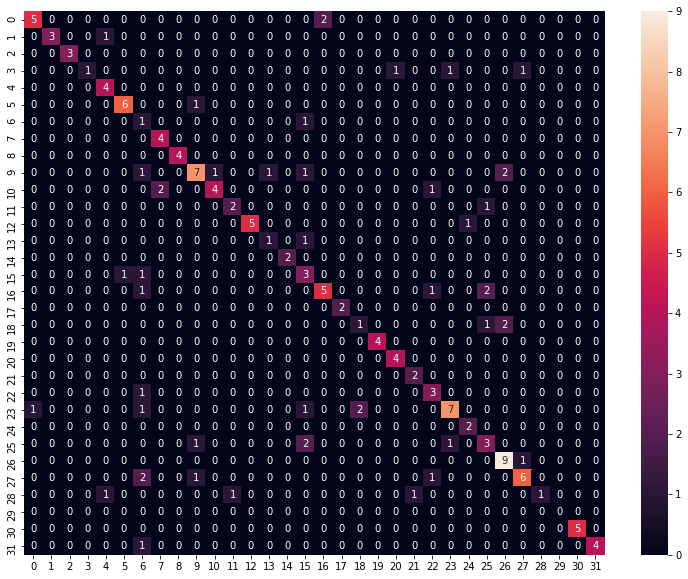

In [ ]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay

y_pred = model_32M.predict(evaluate_dataset,
                          verbose=0, steps=3,
                          callbacks=None,
                          max_queue_size=10,
                          workers=1, use_multiprocessing=False)

y_pred_c = np.argmax(y_pred, axis=1)

y_real=[]
for i in range(0,3):
  y_real.append(list(evaluate_dataset.take(3).as_numpy_iterator())[i][1]) #itera en las tuplas (features, etiquetas) de 3 batches

y_real= np.concatenate((y_real[0], y_real[1], y_real[2]), axis=0)
print(f'Predichas: {y_pred_c}')
print(f'Reales: {y_real}')

cm = confusion_matrix(y_real, y_pred_c, labels=range(0, 32))
fig, ax = plt.subplots(1,1, figsize=(13, 10))
sns.heatmap(cm, annot=True, ax=ax);

In [ ]:
print(dict_label2encoded(listdir), end=',')

{0: 'Atlantic Spotted Dolphin', 1: 'Bearded Seal', 2: 'Beluga, White Whale', 3: 'Bottlenose Dolphin', 4: 'Bowhead Whale', 5: 'Clymene Dolphin', 6: 'Common Dolphin', 7: 'False Killer Whale', 8: 'Fin, Finback Whale', 9: 'Fraser_s Dolphin', 10: 'Grampus, Risso_s Dolphin', 11: 'Harp Seal', 12: 'Humpback Whale', 13: 'Killer Whale', 14: 'Leopard Seal', 15: 'Long-Finned Pilot Whale', 16: 'Melon Headed Whale', 17: 'Minke Whale', 18: 'Narwhal', 19: 'Northern Right Whale', 20: 'Pantropical Spotted Dolphin', 21: 'Ross Seal', 22: 'Rough-Toothed Dolphin', 23: 'Short-Finned (Pacific) Pilot Whale', 24: 'Southern Right Whale', 25: 'Sperm Whale', 26: 'Spinner Dolphin', 27: 'Striped Dolphin', 28: 'Walrus', 29: 'Weddell Seal', 30: 'White-beaked Dolphin', 31: 'White-sided Dolphin'},

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_real, y_pred_c, digits= 4)
print(report)

              precision    recall  f1-score   support

           0     0.8333    0.7143    0.7692         7
           1     1.0000    0.7500    0.8571         4
           2     1.0000    1.0000    1.0000         3
           3     1.0000    0.2500    0.4000         4
           4     0.6667    1.0000    0.8000         4
           5     0.8571    0.8571    0.8571         7
           6     0.1111    0.5000    0.1818         2
           7     0.6667    1.0000    0.8000         4
           8     1.0000    1.0000    1.0000         4
           9     0.7000    0.5385    0.6087        13
          10     0.8000    0.5714    0.6667         7
          11     0.6667    0.6667    0.6667         3
          12     1.0000    0.8333    0.9091         6
          13     0.5000    0.5000    0.5000         2
          14     1.0000    1.0000    1.0000         2
          15     0.3333    0.6000    0.4286         5
          16     0.7143    0.5556    0.6250         9
          17     1.0000    

## Modelo 02 - Convolucional 32
---

In [ ]:
import cv2 as cv

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#########################
img_size = (560, 60) #tamaño de las imagenes
#########################
def generator():
  """
  new_list = []
  for audio in listdir:
    split_name = re.split(r'(\d*\.)', audio, maxsplit=2)
    split_name[1] = int(re.sub(r'[\.]', '', split_name[1]))
  
    if split_name[0] != 'Weddell Seal' and split_name[0] != 'Leopard Seal':
      new_list.append(audio)
    else:
      continue 
  """
  new_list = listdir

  cetaceo = []
  for i in range(0, len(new_list)):

    split_name = re.split(r'(\d*\.)', new_list[i], maxsplit=2)
    split_name[1] = int(re.sub(r'[\.]', '', split_name[1]))
    cetaceo.append(split_name[0])

  etiquetas = preprocessing.LabelEncoder().fit_transform(cetaceo)

  for i in range(0, len(new_list)):
    get_sr = librosa.get_samplerate(pathdir+new_list[i])
    y, sr = librosa.load(pathdir+new_list[i], sr= get_sr, res_type='kaiser_fast')
    mfccs=librosa.feature.mfcc(y=y,sr=sr, n_mfcc=60)
    sc = StandardScaler().fit_transform(mfccs)
    img_resize = cv.resize(sc, img_size,
                           interpolation = cv.INTER_CUBIC)
    #print(img_resize.shape, etiquetas[i].shape)
    print("@", end='')
    yield img_resize, etiquetas[i]


In [ ]:
it = iter(generator())
next(it)

@

(array([[-7.1500893e+00, -7.1498399e+00, -7.1497145e+00, ...,
         -7.1967731e+00, -7.1969290e+00, -7.1972399e+00],
        [ 2.6070786e+00,  2.6072989e+00,  2.6074085e+00, ...,
          2.5101676e+00,  2.5098825e+00,  2.5093105e+00],
        [ 3.8555626e-02,  3.8452473e-02,  3.8401052e-02, ...,
         -3.0252509e-02, -3.0239124e-02, -3.0212268e-02],
        ...,
        [ 4.5739472e-02,  4.5690212e-02,  4.5665663e-02, ...,
          5.2246001e-02,  5.2304566e-02,  5.2422076e-02],
        [ 4.3328167e-03,  4.7391509e-03,  4.9416795e-03, ...,
         -8.6369574e-02, -8.6298764e-02, -8.6156674e-02],
        [ 2.1568193e-01,  2.1727394e-01,  2.1806744e-01, ...,
         -6.0418043e-02, -6.0542557e-02, -6.0792390e-02]], dtype=float32), 19)

In [ ]:
print(next(it)[0].shape)

@(60, 560)


In [ ]:
######################
batch_size = 64
######################
print(f'número de batch: {round(len(listdir)/batch_size)} de tamaño {batch_size}')
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape= (60, 560), 
                                                                       dtype=tf.float64), 
                                                                       tf.TensorSpec(shape=(), 
                                                                       dtype=tf.int32))).cache().shuffle(len(listdir), reshuffle_each_iteration=False).batch(batch_size)#.repeat() #shuffle si afecta la generación
                                                                                                                                  #reshuffle: cada ves que lo ejecutemos barajará diferente
                                                                                                                                  #cache(): sirve para no tenenr que generar todo de nuevo cada ves que se reinicie el generador
print(dataset.element_spec)                                                                                                                                  


número de batch: 27 de tamaño 64
(TensorSpec(shape=(None, 60, 560), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
print(list(dataset.take(1).as_numpy_iterator())[0][0].shape) #shape de 1 solo batch sin etiquetas solo features
print(list(dataset.take(1).as_numpy_iterator())[0]) #una tupla (features, etiquetas) de un solo batch

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=907
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1611
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1806
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1809
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1242
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1815
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/

@@@@@@@@@@@@@@

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1209
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=907
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1209
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1815
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1815
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1209
  n_fft, y.shape[-1]


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
num_batch = int(len(listdir)/batch_size)
print(len(listdir)/batch_size)
print(f'prueba 10%: take {round(num_batch*0.1)} batches') #10
print(f'val 10%: take {round(num_batch*0.1)} batches') #10
print(f'train 80%: take {round(num_batch*0.8)} batches') #80
num_batch_train = round(num_batch*0.8)
num_batch_val = round(num_batch*0.1)

train_dataset = dataset.take(num_batch_train)
test_dataset = dataset.skip(num_batch_train).take(num_batch_val)
evaluate_dataset = dataset.skip(num_batch_train + num_batch_val).take(num_batch_val)

#train_dataset = dataset.skip(num_batch_train)
print(test_dataset.element_spec) #shape de las etiquetas
print(train_dataset.element_spec)
print(evaluate_dataset.element_spec)

26.515625
prueba 10%: take 3 batches
val 10%: take 3 batches
train 80%: take 21 batches
(TensorSpec(shape=(None, 60, 560), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 60, 560), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 60, 560), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
print(f'train_dataset batches: {len(list(train_dataset.as_numpy_iterator()))}')
print(f'test_dataset batches: {len(list(test_dataset.as_numpy_iterator()))}') 
print(f'evaluate_dataset batches: {len(list(evaluate_dataset.as_numpy_iterator()))}')#numero de batches

train_dataset batches: 21
test_dataset batches: 3
evaluate_dataset batches: 3


In [ ]:
#ahora hacemos que cada uno se repita indefinidamente para entrenar varias epochs
train_dataset  = train_dataset.repeat()
test_dataset = test_dataset.repeat()
evaluate_dataset = evaluate_dataset.repeat()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras import utils


inputs = Input(shape =img_size[::-1])
x = layers.Reshape((img_size[0], img_size[1], 1), input_shape=(500, 500))(inputs)
print(f'output inputs: {inputs.shape}')
#encoder
#input = 28 x 28 x 1 (wide and thin)
x = layers.Activation('tanh')(x)
conv1 = layers.Conv2D(4, (3, 3), activation='tanh', strides=(2, 2),padding='same')(x) 
print(f'output conv1: {conv1.shape}') #(None, 24, 24, 1)
max1 = layers.MaxPool2D(2,2)(conv1)
conv2 = layers.Conv2D(16, (3, 3), activation='tanh', strides=(2, 2),padding='same')(max1)
max2 = layers.MaxPool2D(2,2)(conv2)
print(f'output conv2: {conv2.shape}') #(None, 12, 12, 4)
conv3 = layers.Conv2D(32, (3, 3), activation='tanh', strides=(2, 2),padding='same')(max2)
max3 = layers.MaxPool2D(2,2)(conv3)
print(f'output conv3: {conv3.shape}') #(None, 3, 3, 32)
conv4 = layers.Conv2D(64, (3, 3), activation='tanh', strides=(2,2),padding='same')(max3) #2 x 2 x 64

# Save the shape to the decoder
shape = conv3.shape#.as_list()
print(f'output conv3: {shape}') #(None, 2, 2, 64)
flat = layers.Flatten()(conv4)#(max3)
print(f'output flat: {flat.shape}') #(None, 256
densa = layers.Dense(64, activation='tanh',name ='densa')(flat)
drop = layers.Dropout(0.6)(densa)
print(f'output densa: {densa.shape}')
encoded = layers.Dense(32, activation='softmax',name ='latent_vector')(drop) 
#la capa de salida debe ser del mismo tamaño de las etiquetas
print(f'output dense: {encoded.shape}')
modelconv_mel = Model(inputs, encoded, name ='encoder')

output inputs: (None, 60, 560)
output conv1: (None, 280, 30, 4)
output conv2: (None, 70, 8, 16)
output conv3: (None, 18, 2, 32)
output conv3: (None, 18, 2, 32)
output flat: (None, 320)
output densa: (None, 64)
output dense: (None, 32)


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 560)]         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 560, 60, 1)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 560, 60, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 280, 30, 4)        40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 140, 15, 4)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 70, 8, 16)         592       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 35, 4, 16)         0   

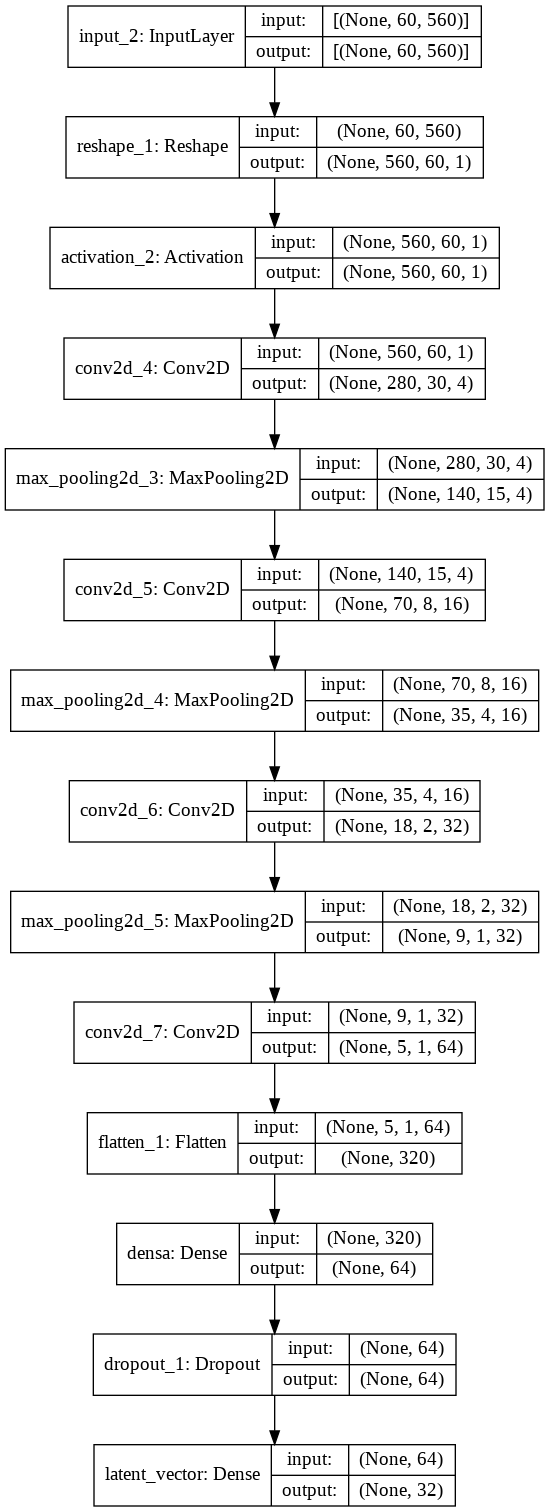

In [ ]:
from tensorflow.keras import utils
#from tensorflow.keras.optimizers import RMSprop

modelconv_mel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
modelconv_mel.summary()
utils.plot_model(modelconv_mel, show_shapes=True)

In [ ]:
epocas = 2

print(f'TRAIN: \nEn {epocas} épocas debe haber {round(num_batch*0.8)/epocas} steps_per_epoch')
print(f'TEST: \nEn {epocas} épocas debe haber {round(num_batch*0.1)/epocas} validation_steps')

TRAIN: 
En 2 épocas debe haber 10.5 steps_per_epoch
TEST: 
En 2 épocas debe haber 1.5 validation_steps


In [ ]:
history = modelconv_mel.fit(train_dataset, epochs= 170,
                      validation_data= test_dataset, 
                      steps_per_epoch= round((num_batch*0.8)/epocas), 
                      validation_steps= round((num_batch*0.1)/epocas))
  #validation_steps= y steps_per_epoch= es fundamental para que no salga n/unknow en los pasos

Epoch 1/170
10/10 [==============================] - 1s 40ms/step - loss: 3.4506 - accuracy: 0.0367 - val_loss: 3.3667 - val_accuracy: 0.1406
Epoch 2/170
10/10 [==============================] - 0s 23ms/step - loss: 3.3606 - accuracy: 0.0557 - val_loss: 3.2521 - val_accuracy: 0.1719
Epoch 3/170
10/10 [==============================] - 0s 24ms/step - loss: 3.2558 - accuracy: 0.0966 - val_loss: 3.1423 - val_accuracy: 0.1562
Epoch 4/170
10/10 [==============================] - 0s 24ms/step - loss: 3.1176 - accuracy: 0.1392 - val_loss: 3.0016 - val_accuracy: 0.1719
Epoch 5/170
10/10 [==============================] - 0s 25ms/step - loss: 3.0155 - accuracy: 0.1523 - val_loss: 2.8866 - val_accuracy: 0.2031
Epoch 6/170
10/10 [==============================] - 0s 24ms/step - loss: 2.8352 - accuracy: 0.2187 - val_loss: 2.8015 - val_accuracy: 0.2656
Epoch 7/170
10/10 [==============================] - 0s 24ms/step - loss: 2.7597 - accuracy: 0.2609 - val_loss: 2.7313 - val_accuracy: 0.3281
Epoch 

In [ ]:
modelconv_mel.evaluate(evaluate_dataset, steps=round((num_batch*0.1))) 

3/3 [==============================] - 0s 10ms/step - loss: 0.7140 - accuracy: 0.8323


[0.7140348553657532, 0.8322981595993042]

In [ ]:
modelconv_mel.save('/content/drive/MyDrive/Cetaceos/Cetaceos_conv32.h5') #guardamos el modelo entrenado y evaluado

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
165,0.273080,0.928125,1.073397,0.750000,165
166,0.269771,0.929688,1.137083,0.718750,166
167,0.266138,0.926562,1.171098,0.687500,167
168,0.275759,0.921875,1.121203,0.703125,168
169,0.267068,0.928125,1.155113,0.703125,169


In [ ]:
hist[(hist['val_accuracy'] >= 0.8)] #las precisiones de validación más altas

,loss,accuracy,val_loss,val_accuracy,epoch


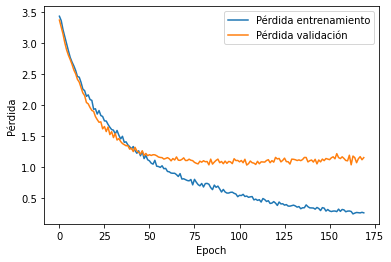

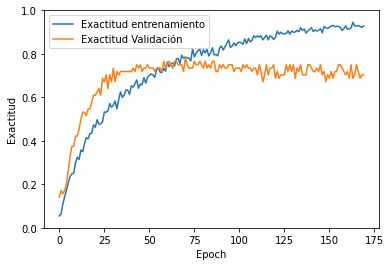

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],
           label='Pérdida entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Pérdida validación')
  #plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Exactitud')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Exactitud entrenamiento')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Exactitud Validación')
  plt.ylim([0,1])
  plt.legend()
  plt.show()
plot_history(history)

[31  9 28 27 20 27 19 15 25 23 30 19  2  1 23  7 19 20  8 20  9 20 11  0
 30  9 19 19 10 25  7 23  0 10 25 12 28  9 28  7 26 22 22 12 21  4  9  9
 15 22  9 27 16  4 22 10 20 21  2 27 24  4 25  0 26  0 16  8 30  3 15 24
 10 28 19 27 30  5 15 30 31 22 17 25 28 26 10  6  5 23  6  2  6  2 16 20
  7 18 25 12 11 25 21  7 19  4 23 25  9 16 22 28 21 18 16  5 18 18 12  3
 27 12 10  6  8 25 31 31 10  9 28  9 20  4 22 27 27 11 27  4 26 10 21 28
 10  3 30 12  6 26  9 10  4 27  6  9 15 17  0 11  5]
[31  9 28 27 26 27 19 15 16 23 30 19 17  1 15  7 19 20  8 20  9 20 11  0
 30  9 28 19 10 25  7 23 16 10 16 12  4  9 28  7 26 22 22 12 21  4  9  9
 15 10  9 27 16  4 22 10 20 21  2 27 24  1 26  0 26  0 16  8 30  3 15 24
 10 24 19 27 30  7 15 30 31 22 17 25 28 26 10  6 27 23 11  2  6  0 16 20
  7 18 25 12 11 23 21  7 19  4 15 25  9 16 22 28 21 18 16  5 18 18 12  3
 27 12 10  6  8 16 31 31 10  9 28  9 20  1 22 27 27  2 27  4 26 10 21 28
 10  3 30 12 12 26  9 10 19  6  6 16 15  2  0 11 22]


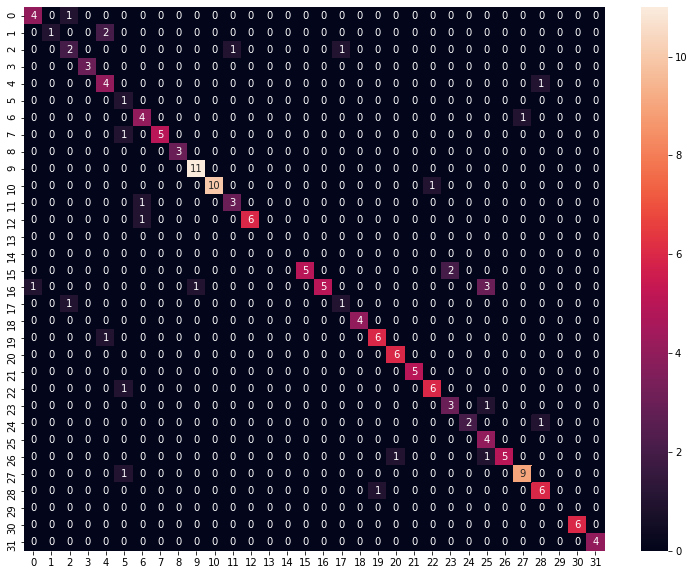

In [ ]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay

y_pred = modelconv_mel.predict(evaluate_dataset,
                          verbose=0, steps=3,
                          callbacks=None,
                          max_queue_size=10,
                          workers=1, use_multiprocessing=False)

y_pred_c = np.argmax(y_pred, axis=1)

y_real=[]
for i in range(0,3):
  y_real.append(list(evaluate_dataset.take(3).as_numpy_iterator())[i][1]) #itera en las tuplas (features, etiquetas) de 3 batches

y_real= np.concatenate((y_real[0], y_real[1], y_real[2]), axis=0)
print(y_pred_c)
print(y_real)

cm = confusion_matrix(y_real, y_pred_c, labels=range(0, 32))
fig, ax = plt.subplots(1,1, figsize=(13, 10))
sns.heatmap(cm, annot=True, ax=ax);

In [ ]:
def dict_label2encoded(listdir):
  cetaceo = []
  for i in range(0, len(listdir)):
    split_name = re.split(r'(\d*\.)', listdir[i], maxsplit=2)
    split_name[1] = int(re.sub(r'[\.]', '', split_name[1]))
    cetaceo.append(split_name[0])

  Lable_encoder = preprocessing.LabelEncoder().fit(cetaceo)
  mat_labels = {i: name for i, name in enumerate(Lable_encoder.inverse_transform(range(0, 32)))}
  return mat_labels

In [ ]:
print(dict_label2encoded(listdir), end=',')

{0: 'Atlantic Spotted Dolphin', 1: 'Bearded Seal', 2: 'Beluga, White Whale', 3: 'Bottlenose Dolphin', 4: 'Bowhead Whale', 5: 'Clymene Dolphin', 6: 'Common Dolphin', 7: 'False Killer Whale', 8: 'Fin, Finback Whale', 9: 'Fraser_s Dolphin', 10: 'Grampus, Risso_s Dolphin', 11: 'Harp Seal', 12: 'Humpback Whale', 13: 'Killer Whale', 14: 'Leopard Seal', 15: 'Long-Finned Pilot Whale', 16: 'Melon Headed Whale', 17: 'Minke Whale', 18: 'Narwhal', 19: 'Northern Right Whale', 20: 'Pantropical Spotted Dolphin', 21: 'Ross Seal', 22: 'Rough-Toothed Dolphin', 23: 'Short-Finned (Pacific) Pilot Whale', 24: 'Southern Right Whale', 25: 'Sperm Whale', 26: 'Spinner Dolphin', 27: 'Striped Dolphin', 28: 'Walrus', 29: 'Weddell Seal', 30: 'White-beaked Dolphin', 31: 'White-sided Dolphin'},

In [ ]:
#pd.DataFrame(dict_label2encoded(listdir).keys(), rows=dict_label2encoded(listdir).values())
hola = pd.DataFrame(dict_label2encoded(listdir).items(), columns=['Encoded', 'Cetáceo'])
hola['diag_cm'] = cm.diagonal()
hola

,Encoded,Cetáceo,diag_cm
0,0,Atlantic Spotted Dolphin,4
1,1,Bearded Seal,1
2,2,"Beluga, White Whale",2
3,3,Bottlenose Dolphin,3
4,4,Bowhead Whale,4
5,5,Clymene Dolphin,1
6,6,Common Dolphin,4
7,7,False Killer Whale,5
8,8,"Fin, Finback Whale",3
9,9,Fraser_s Dolphin,11


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_real, y_pred_c, digits= 4)
print(report)

              precision    recall  f1-score   support

           0     0.8000    0.8000    0.8000         5
           1     1.0000    0.3333    0.5000         3
           2     0.5000    0.5000    0.5000         4
           3     1.0000    1.0000    1.0000         3
           4     0.5714    0.8000    0.6667         5
           5     0.2500    1.0000    0.4000         1
           6     0.6667    0.8000    0.7273         5
           7     1.0000    0.8333    0.9091         6
           8     1.0000    1.0000    1.0000         3
           9     0.9167    1.0000    0.9565        11
          10     1.0000    0.9091    0.9524        11
          11     0.7500    0.7500    0.7500         4
          12     1.0000    0.8571    0.9231         7
          15     1.0000    0.7143    0.8333         7
          16     1.0000    0.5000    0.6667        10
          17     0.5000    0.5000    0.5000         2
          18     1.0000    1.0000    1.0000         4
          19     0.8571    

##Modelo 03 - Denso29
---

In [ ]:
#carga el csv desde drive
df_metadata = pd.read_csv (r'/content/drive/MyDrive/Cetaceos/Mammals2.csv') #en drive
df_metadata
df=df_metadata[['Cétaceos','número']]

## Pipeline Modelo 03
---

In [ ]:
def parser(row):
  file_name=os.path.join('drive/MyDrive/Cetaceos/Audios/', str(row.Cétaceos) + str(row.número) +'.mp4')
  file_name= file_name.replace(u'\xa0', u'')
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  mfccs=np.mean(librosa.feature.mfcc(y=x,sr=sample_rate, n_mfcc=60).T,axis=0)

  feature=mfccs
  label=row.Cétaceos

  return[feature,label] 

In [ ]:
data=df.apply(parser,axis=1)
df.columns=['feature','label']
df.shape

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1184
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1812
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1448
  n_fft, y.shape[-1]


(1668, 2)

In [ ]:
X=np.array(list(zip(*data))[0])
y=np.array(list(zip(*data))[1])

## Ajustar Modelo 03
---

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
le=LabelEncoder()
y=np_utils.to_categorical(le.fit_transform(y))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay
print("Versión de Tensorflow:", tf.__version__)

Versión de Tensorflow: 2.4.1


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=0)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1334, 60)
(1334, 29)
(334, 60)
(334, 29)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_inicial (InputLayer)    [(None, 60)]              0         
_________________________________________________________________
activation_4 (Activation)    (None, 60)                0         
_________________________________________________________________
Primera_capa_oculta (Dense)  (None, 128)               7808      
_________________________________________________________________
Primera_capa_dropout (Dropou (None, 128)               0         
_________________________________________________________________
Segunda_capa_oculta (Dense)  (None, 128)               16512     
_________________________________________________________________
Segunda_capa_dropout (Dropou (None, 128)               0         
_________________________________________________________________
Tercera_capa_oculta (Dense)  (None, 128)               1651

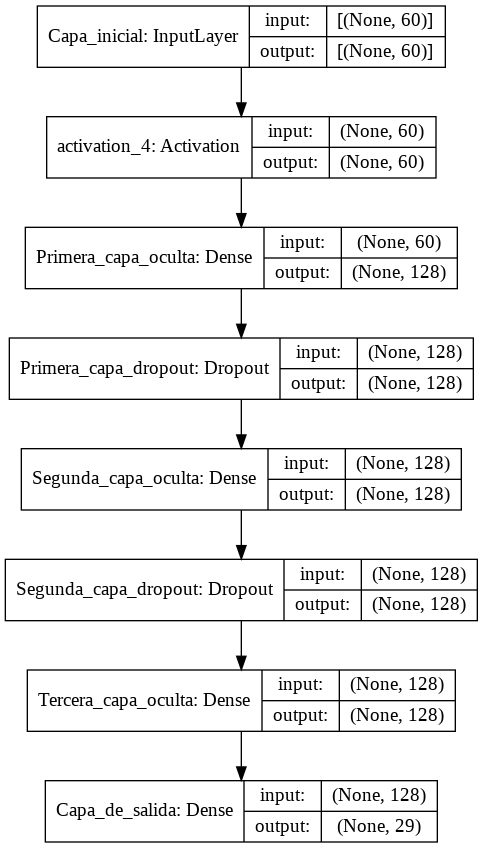

In [ ]:
inputs=Input(shape=(60,), name='Capa_inicial')

model_29M=Activation('tanh')(inputs)
model_29M=Dense(128, activation='relu', name='Primera_capa_oculta')(model_29M)
model_29M= Dropout(.4, name='Primera_capa_dropout')(model_29M)
model_29M=Dense(128, activation='relu', name='Segunda_capa_oculta')(model_29M)
model_29M= Dropout(.4, name='Segunda_capa_dropout')(model_29M)
model_29M=Dense(128, activation='relu', name='Tercera_capa_oculta')(model_29M)


outputs=Dense(29,name='Capa_de_salida')(model_29M)

model_29M=Model(inputs=inputs, outputs=outputs)

model_29M.summary()
plot_model(model_29M, to_file='drive/MyDrive/Cetaceos/model_29M.png', show_shapes=True)

## Aplicar Modelo 03
---

In [ ]:
model_29M.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

class Printline(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('-', end='')
epochs = 100

history = model_29M.fit(X_train, Y_train,
                    batch_size= 10,
                    epochs= epochs,
                    validation_split=0.10, verbose=0,
                    callbacks=[Printline()])


----------------------------------------------------------------------------------------------------

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,0.226374,0.917500,0.593568,0.828358,95
96,0.217682,0.928333,0.648411,0.820895,96
97,0.193126,0.934167,0.564985,0.820895,97
98,0.185730,0.937500,0.712145,0.820895,98
99,0.233381,0.907500,0.655713,0.820895,99


## Analisis de performance Modelo 03
---

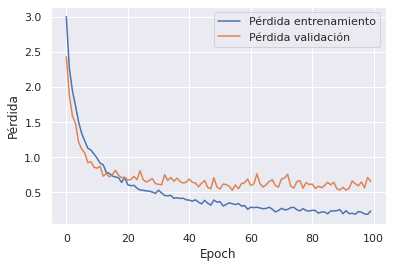

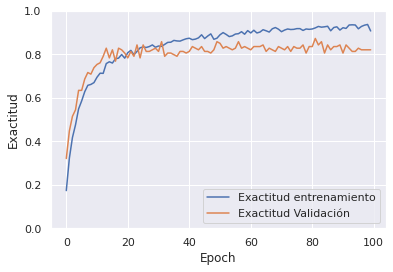

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],
           label='Pérdida entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Pérdida validación')
  #plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Exactitud')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Exactitud entrenamiento')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Exactitud Validación')
  plt.ylim([0,1])
  plt.legend()
  plt.show()
plot_history(history)

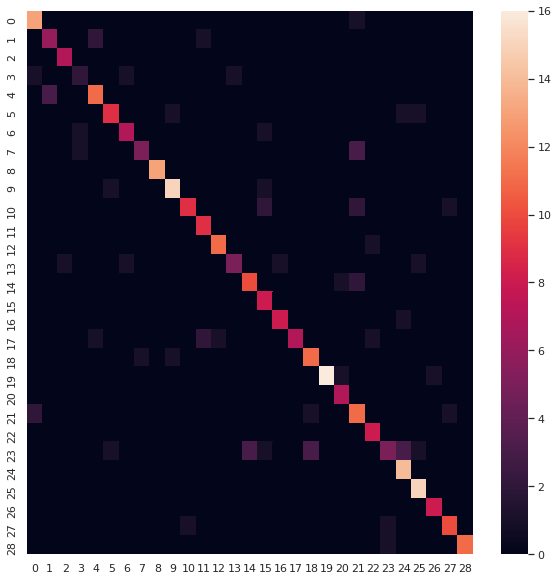

In [ ]:
y_pred = model_29M.predict(X_test)
y_pred_c = np.argmax(y_pred, axis=1)

import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

matrix = sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax = sns.heatmap(matrix)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1), digits= 4)
print(report)

              precision    recall  f1-score   support

           0     0.8125    0.9286    0.8667        14
           1     0.6667    0.6667    0.6667         9
           2     0.8750    1.0000    0.9333         7
           3     0.5000    0.4000    0.4444         5
           4     0.7857    0.7857    0.7857        14
           5     0.8182    0.7500    0.7826        12
           6     0.7778    0.7778    0.7778         9
           7     0.8333    0.5556    0.6667         9
           8     1.0000    1.0000    1.0000        13
           9     0.8824    0.8824    0.8824        17
          10     0.9000    0.6429    0.7500        14
          11     0.7500    1.0000    0.8571         9
          12     0.9167    0.9167    0.9167        12
          13     0.8333    0.5556    0.6667         9
          14     0.7692    0.7692    0.7692        13
          15     0.6154    1.0000    0.7619         8
          16     0.8889    0.8889    0.8889         9
          17     1.0000    